# Assignment: Trees

## Do two questions in total: "Q1+Q2" or "Q1+Q3"

`! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Please answer the following questions in your own words.
1. Why is the Gini a good loss function for categorical target variables? 

Because it is a clear and intuitive measure of how much that data is split into each class of the categorical target variable. 

2. Why do trees tend to overfit, and how can this tendency be constrained? 

Trees tend to overfit because they learn the training set too well as they build a complex and deep decision tree, so they capture noise or random fluctuations in the training data, rather than learning the underlying patterns that generalize well to unseen data.
To constrain the tendency of overfitting, we could truncate the tree and limit its depth, so that it isn't making splits on very fine distinctions among a handful of observations. Also, we could impose a lower bound on the impurity that can appear at a terminal node (don't allow the terminal nodes to be "too pure"), or we could impose a limit on how few cases can appear at a terminal node (don't allow the terminal nodes to be "too small"). 

3. True or false, and explain: Trees only really perform well in situations with lots of categorical variables as features/covariates. 

False. Decision trees can handle both categorical and numerical variables effectively and they are good at capturing non-linear relationships for the continuous variables. 

4. Why don't most versions of classification/regression tree concept allow for more than two branches after a split?

Because when we are choosing the sub-nodes, we are choosing the one that minimizes the impurity of the resulting subsets, so that we constrain the tendency of overfitting. 

5. What are some heuristic ways you can examine a tree and decide whether it is probably over- or under-fitting?

We could split the sample dataset into training data and testing data, and then use the testing data to find out how the model perform and see if it is over- or under-fitting. Also, we could calculate the accuracy based on the confusion matrix to determine the performance, or carefully stop to avoid overfitting, 

**Q2.** This is a case study about classification and regression trees.

1. Load the `Breast Cancer METABRIC.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/Breast Cancer METABRIC.csv")
print(df.shape) # 2509 observations, 34 variables
df.head()

(2509, 34)


,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


2.  We'll use a consistent set of feature/explanatory variables. For numeric variables, we'll include `Tumor Size`, `Lymph nodes examined positive`, `Age at Diagnosis`. For categorical variables, we'll include `Tumor Stage`, `Chemotherapy`, and `Cancer Type Detailed`. One-hot-encode the categorical variables and concatenate them with the numeric variables into a feature/covariate matrix, $X$.

In [3]:
df1 = df.dropna(subset=['Overall Survival Status']) #from later we know our y is this column. 
#Clean it here so our X could be handled as well

In [4]:
# Dummy variables:
tumor_dummy = pd.get_dummies(df1['Tumor Stage'])
chemo_dummy = pd.get_dummies(df1['Chemotherapy'])
type_dummy = pd.get_dummies(df1['Cancer Type Detailed'])

# rename columns
tumor_dummy = tumor_dummy.rename(columns = {0.0: "tumor_0", 1.0: "tumor_1", 2.0: "tumor_2", 3.0: "tumor_3",
                                                    4.0: "tumor_4", 5.0: "tumor_5"})
chemo_dummy = chemo_dummy.rename(columns= {"No": "Chemo_No", "Yes": "Chemo_Yes"})
vars = ["Tumor Size", "Lymph nodes examined positive", "Age at Diagnosis"]
X = pd.concat([df1.loc[:,vars], tumor_dummy, chemo_dummy, type_dummy],axis=1)
X.head()


,Tumor Size,Lymph nodes examined positive,Age at Diagnosis,tumor_0,tumor_1,tumor_2,tumor_3,tumor_4,Chemo_No,Chemo_Yes,Breast,Breast Angiosarcoma,Breast Invasive Ductal Carcinoma,Breast Invasive Lobular Carcinoma,Breast Invasive Mixed Mucinous Carcinoma,Breast Mixed Ductal and Lobular Carcinoma,Invasive Breast Carcinoma,Metaplastic Breast Cancer
0,22.0,10.0,75.65,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False
1,10.0,0.0,43.19,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False
2,15.0,1.0,48.87,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False
3,25.0,3.0,47.68,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False
4,40.0,8.0,76.97,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


3. Let's predict `Overall Survival Status` given the features/covariates $X$. There are 528 missing values, unfortunately: Either drop those rows from your data or add them as a category to predict. Constrain the minimum samples per leaf to 10. Print a dendrogram of the tree. Print a confusion matrix of the algorithm's performance. What is the accuracy? 

In [5]:
from sklearn.tree import DecisionTreeClassifier # Import the tree classifier
from sklearn.tree import plot_tree # Import the tree classifier
from sklearn.model_selection import train_test_split # Train/test splitter

In [6]:
y = df1['Overall Survival Status']

# Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

# Fit decision tree:
cart = DecisionTreeClassifier(min_samples_leaf = 10) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

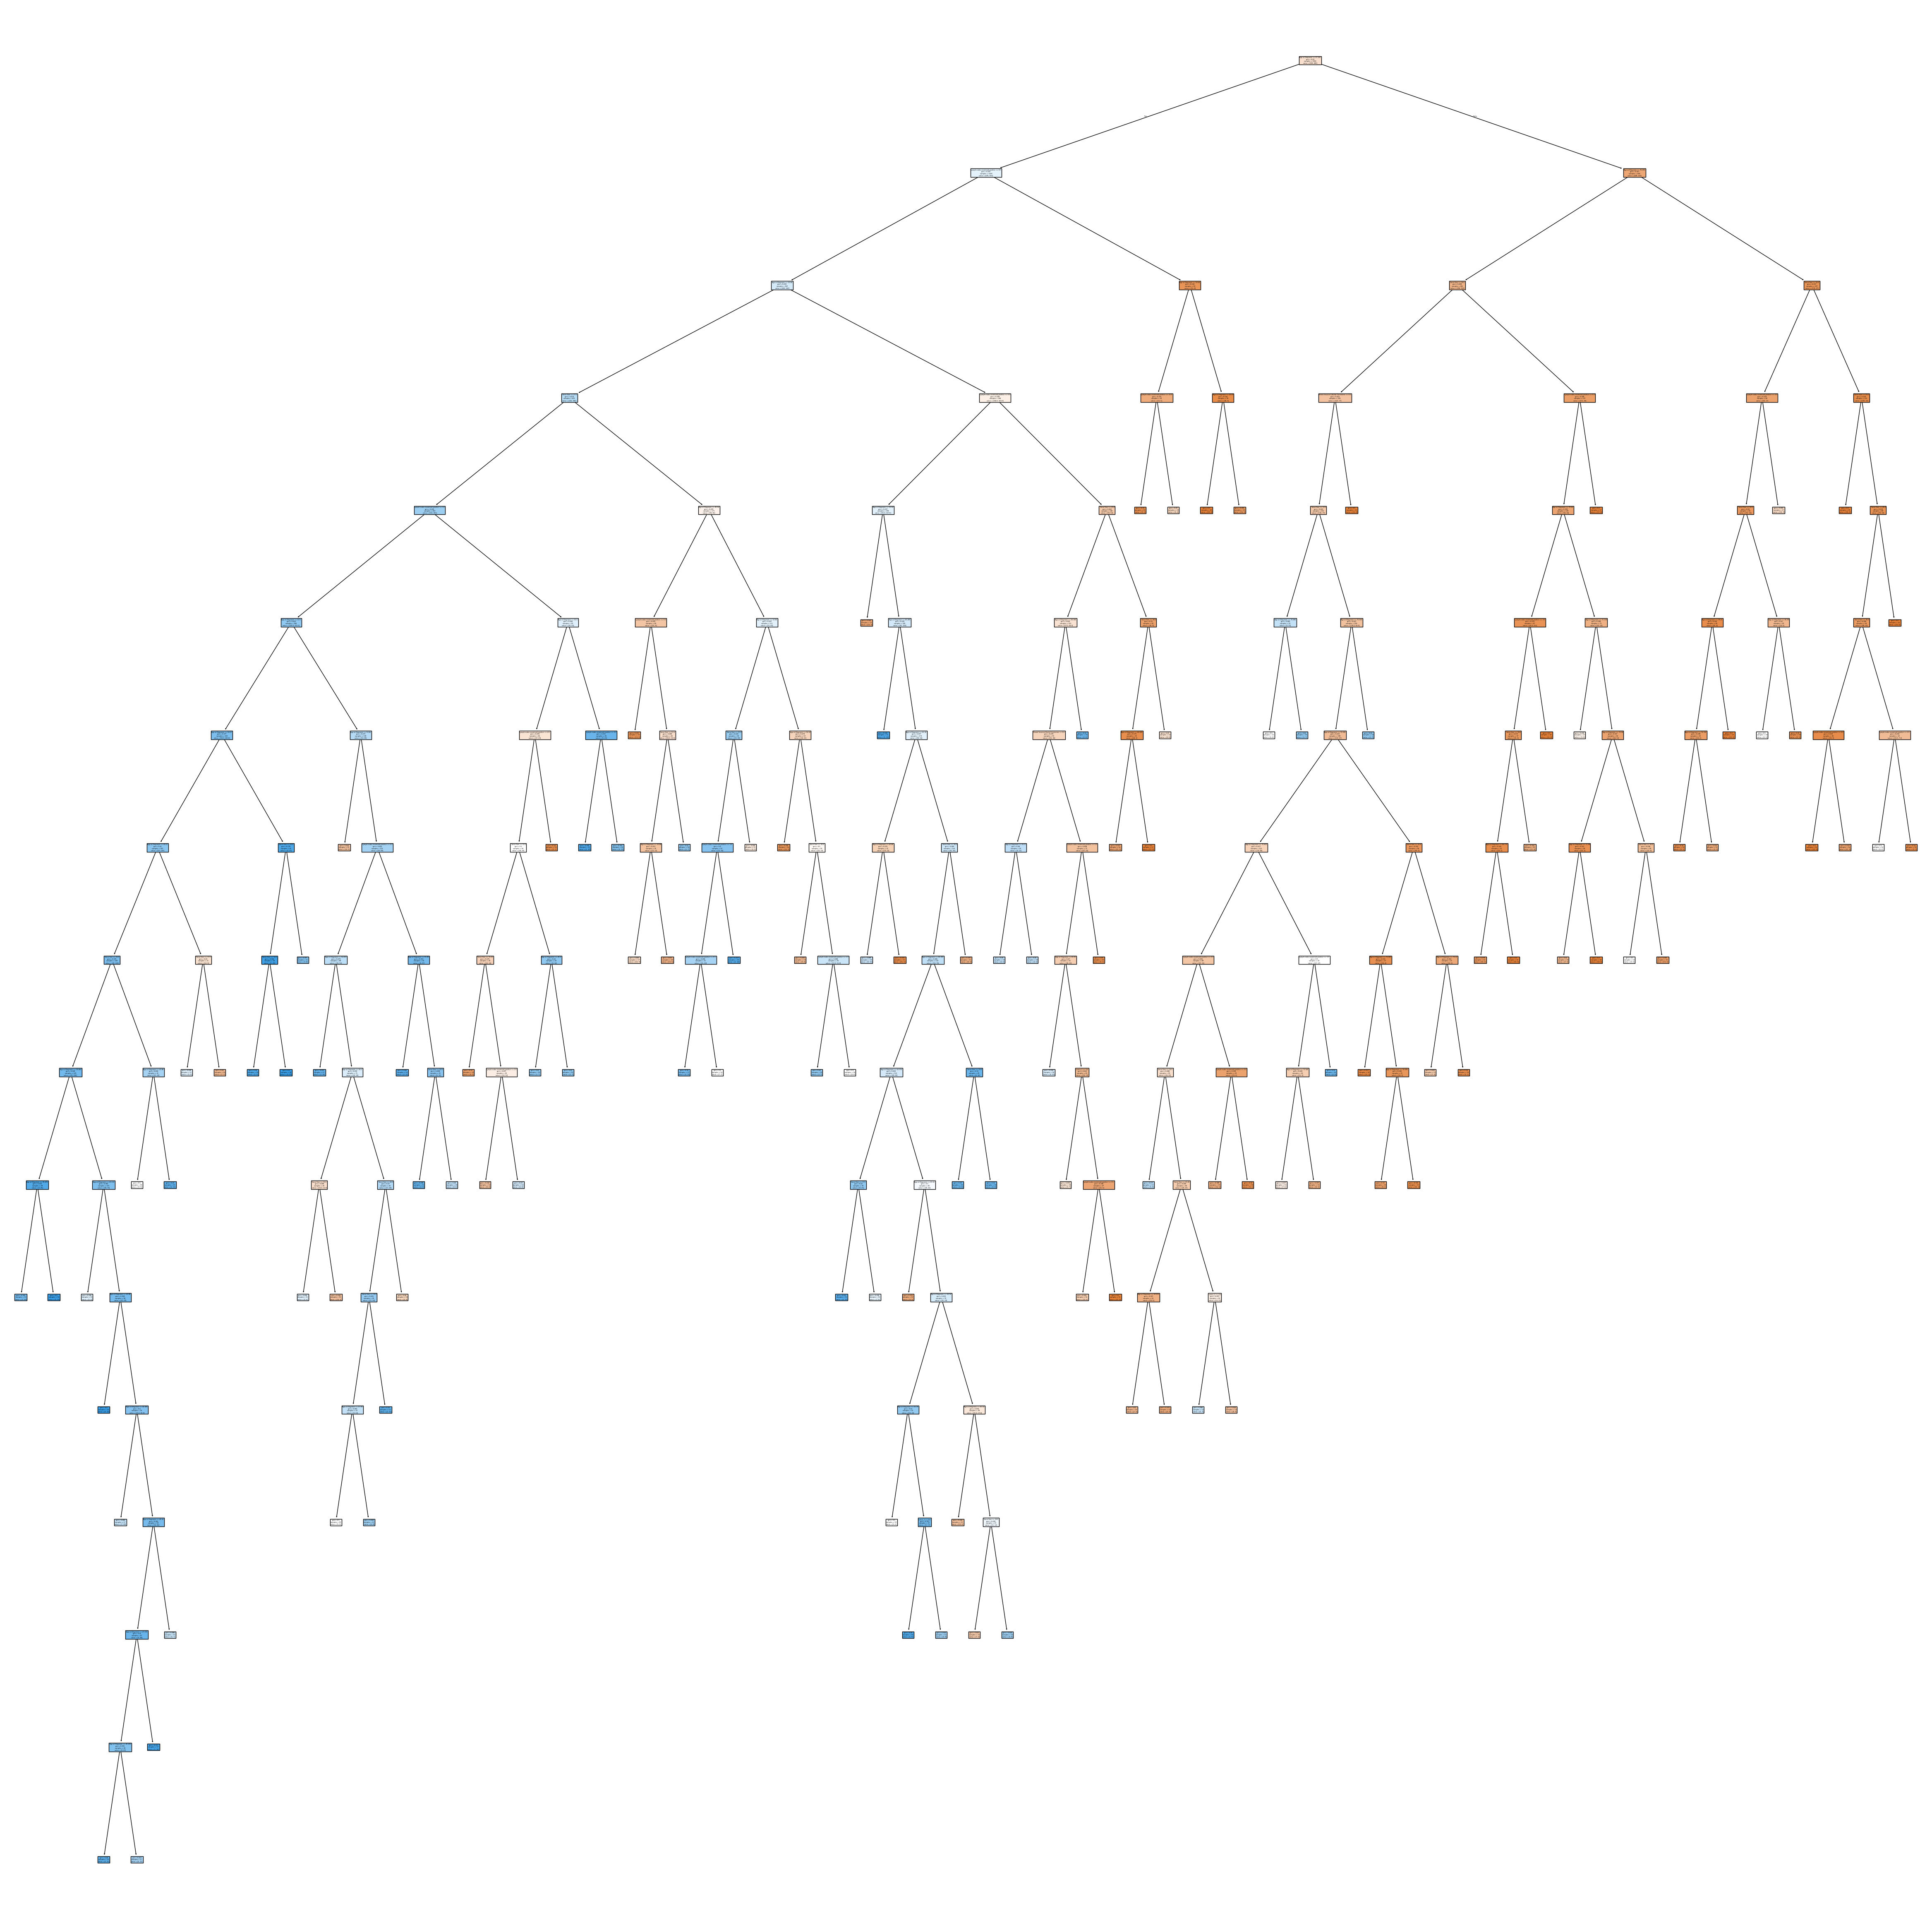

In [7]:
# Visualize results:
plt.figure(figsize=(60,60))
var_names = cart.feature_names_in_
plot_tree(cart,filled=True,feature_names=var_names)
plt.show()

In [8]:
## Confusion Matrix:
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = np.trace(tab)/len(y_test)  # Faster way to compute accuracy
print('Accuracy: ', acc, '\n')
pd.crosstab(y_test,y_hat)

Accuracy:  0.6624685138539043 



col_0,Deceased,Living
Overall Survival Status,,
Deceased,168,72
Living,62,95


4. For your model in part three, compute three statistics:
    - The **true positive rate** or **sensitivity**:
        $$
        TPR = \dfrac{TP}{TP+FN}
        $$
    - The **true negative rate** or **specificity**:
        $$
        TNR = \dfrac{TN}{TN+FP}
        $$
    Does your model tend to perform better with respect to one of these metrics?


In [9]:
TP = tab.iloc[1,1]
TN = tab.iloc[0,0]
FN = tab.iloc[1,0]
FP = tab.iloc[0,1]

TPR = TP/(TP+FN)
TNR = TN/(TN+FP)

print("TPR:", TPR)
print("TNR:", TNR)

TPR: 0.6050955414012739
TNR: 0.7


- 0.586 < 0.704, TPR < TNR, the model tend to perform better with respect to speficity. 


5. Let's predict `Overall Survival (Months)` given the features/covariates $X$. Use the train/test split to pick the optimal `min_samples_leaf` value that gives the highest $R^2$ on the test set (it's about 110). What is the $R^2$? Plot the test values against the predicted values. How do you feel about this model for clinical purposes?

In [10]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor # Import the tree classifier

In [11]:
df2 = df.dropna(subset=['Overall Survival Status']) 

# Dummy variables:
tumor_dummy = pd.get_dummies(df2['Tumor Stage'])
chemo_dummy = pd.get_dummies(df2['Chemotherapy'])
type_dummy = pd.get_dummies(df2['Cancer Type Detailed'])

# rename columns
tumor_dummy = tumor_dummy.rename(columns = {0.0: "tumor_0", 1.0: "tumor_1", 2.0: "tumor_2", 3.0: "tumor_3",
                                                    4.0: "tumor_4", 5.0: "tumor_5"})
chemo_dummy = chemo_dummy.rename(columns= {"No": "Chemo_No", "Yes": "Chemo_Yes"})
vars = ["Tumor Size", "Lymph nodes examined positive", "Age at Diagnosis"]
X = pd.concat([df2.loc[:,vars], tumor_dummy, chemo_dummy, type_dummy],axis=1)
X.head()

y = df2["Overall Survival (Months)"]

# Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

In [12]:
r2_scores = {}
leaf_values = range(5, 151, 5)  # Try values from 5 to 150

for leaf in leaf_values:
    cart = DecisionTreeRegressor(min_samples_leaf=leaf, random_state=100)
    cart.fit(X_train, y_train)
    y_pred = cart.predict(X_test)
    r2_scores[leaf] = r2_score(y_test, y_pred)

best_leaf = max(r2_scores, key=r2_scores.get)
best_r2 = r2_scores[best_leaf]

print(f"Best min_samples_leaf = {best_leaf}")
print(f"Best R^2 on test set = {best_r2:.4f}")


Best min_samples_leaf = 115
Best R^2 on test set = 0.1559


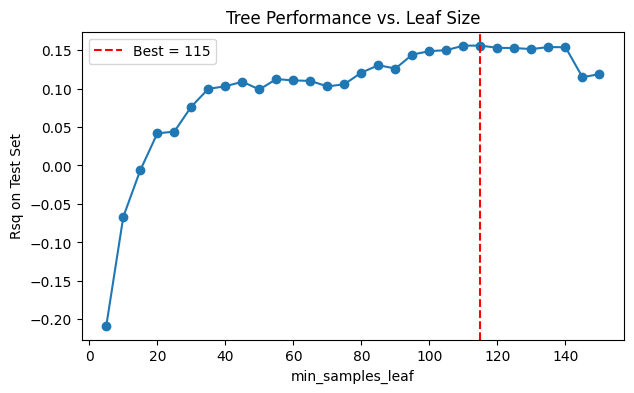

In [13]:
plt.figure(figsize=(7,4))
plt.plot(list(r2_scores.keys()), list(r2_scores.values()), marker='o')
plt.axvline(best_leaf, color='red', linestyle='--', label=f'Best = {best_leaf}')
plt.xlabel("min_samples_leaf")
plt.ylabel("Rsq on Test Set")
plt.title("Tree Performance vs. Leaf Size")
plt.legend()
plt.show()


In [14]:
# Fit decision tree:
best_model = DecisionTreeRegressor(min_samples_leaf = best_leaf) # Create a regressor object
best_model = best_model.fit(X_train, y_train) # Fit the regressor

## Make Predictions on the Test Set
y_hat = cart.predict(X_test)

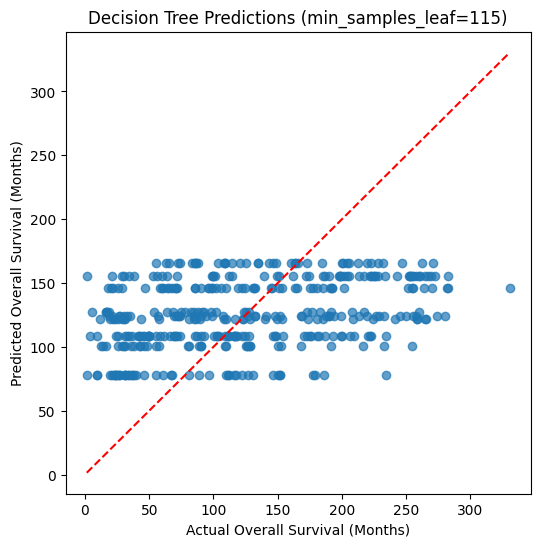

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_hat, alpha=0.7)
plt.xlabel("Actual Overall Survival (Months)")
plt.ylabel("Predicted Overall Survival (Months)")
plt.title(f"Decision Tree Predictions (min_samples_leaf={best_leaf})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.show()


- It does not really predict well with such a low $R^2$ even though it has optimized its `min_samples_leaf`. 
- The scatterplot also shows that there is no clear relationship between the predicted and actual y values. 
---

**Q3.** This is a case study about trees using bond rating data. This is a dataset about bond ratings for different companies, alongside a bunch of business statistics and other data. Companies often have multiple reviews at different dates. We want to predict the bond rating (AAA, AA, A, BBB, BB, B, ..., C, D). Do business fundamentals predict the company's rating?

1. Load the `./data/corporate_ratings.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  Plot a histogram of the `ratings` variable. It turns out that the gradations of AAA/AA/A and BBB/BB/B and so on make it hard to get good results with trees. Collapse all AAA/AA/A ratings into just A, and similarly for B and C.

3. Use all of the variables **except** Rating, Date, Name, Symbol, and Rating Agency Name. To include Sector, make a dummy/one-hot-encoded representation and include it in your features/covariates. Collect the relevant variables into a data matrix $X$. 

4. Do a train/test split of the data and use a decision tree classifier to predict the bond rating. Including a min_samples_leaf constraint can raise the accuracy and speed up computation time. Print a confusion matrix and the accuracy of your model. How well do you predict the different bond ratings?

5. If you include the rating agency as a feature/covariate/predictor variable, do the results change? How do you interpret this?